**Exercise 4.1 (a)**
The log-likelihood is
$$
\ln \mathcal{L} = \sum_{i=1}^{n} \left[-\frac{y_{i}}{X_{i} \beta} - \ln(X_{i} \beta) \right]
$$
So, the FOC is
$$
0 = \sum_{i=1}^{n} \left[\frac{X'_{i} y_{i}}{(X_{i} \beta)^2} - \frac{X'_{i}}{X_{i} \beta} \frac{X_i \beta}{X_{i} \beta} \right] = \sum_{i=1}^{n} \left[\frac{X'_{i} y_{i}}{(X_{i} \beta)^2} - \frac{X'_{i} X_{i}}{(X_{i} \beta)^2} \beta \right]
$$

**Exercise 4.1 (b) and (d)**
From the FOC, we have
$$
\beta = \left[\sum_{i=1}^{n}\frac{X'_{i} X_{i}}{(X_{i} \beta)^2} \right]^{-1} \sum_{i=1}^{n} \frac{X'_{i} y_{i}}{(X_{i} \beta)^2}
$$
so that a possible recursive algorithm to estimate $\beta$ is
$$
\begin{align}
\beta^{(k+1)} &= \left[\sum_{i=1}^{n} \frac{X'_{i} X_{i}}{(X_{i} \beta^{(k)})^2} \right]^{-1} \sum_{i=1}^{n} \frac{X'_{i} y_{i}}{(X_{i} \beta^{(k)})^2} \\
    &= \beta^{(k)} - \left[- \sum_{i=1}^{n} \frac{X'_{i} X_{i}}{(X_{i} \beta^{(k)})^2} \right]^{-1} \sum_{i=1}^{n} \frac{X'_{i} \left(y_{i} - X_{i}\beta^{(k)} \right)}{(X_{i} \beta^{(k)})^2}
\end{align}
$$
Since the last term on the right hand side is the first derivative of the objective function and the matrix in the bracket is symmetric and negative definite, this iteration method can be regarded as quasi Newton method.

In [1]:
# Exercise 4.1 (c)
import numpy as np

def normalize4_1(y, X, b):
    Xb = X @ b
    return X / Xb, y / Xb

def update_param4_1(y, X, b):
    k, Xtilde, ytilde = X.shape[1], *normalize4_1(y, X, b)
    Xy, XX = Xtilde.T @ ytilde, Xtilde.T @ Xtilde

    foc = (Xy - XX @ b).reshape(k,)
    b = np.linalg.inv(XX) @ Xy
    return b, foc

def get_fisher_info(y, X, b, n):
    Xtilde, ytilde = normalize4_1(y, X, b)
    fisher_info_sub = Xtilde * ytilde - Xtilde * (Xtilde @ b)
    return fisher_info_sub.T @ fisher_info_sub / n

def get_asymptotic_variance(y, X, b):
    n = X.shape[0]
    fisher_info = get_fisher_info(y, X, b, n)
    return np.linalg.inv(fisher_info) / n

def func4_1(y, X, tol=1.0e-8):
    """
    - y: n-by-1 matrix
    - X: n-by-K matrix
    """
    n, k = X.shape
    b, foc = np.ones(k).reshape(k, 1), np.ones(k)

    # Estimate parameter
    while any([foc[j] > tol for j in range(k)]):
        b, foc = update_param4_1(y, X, b)

    # Calculate asymptotic variance
    Sigma = get_asymptotic_variance(y, X, b)

    return b, Sigma

# Simulation
np.random.seed(seed=1120002)
n, b = 10000, np.array([[1], [2]])
x = np.random.uniform(0, 5, 2 * n).reshape(n, 2)
y = np.vectorize(np.random.exponential)(x @ b)

b, sigma = func4_1(y, x)
print(b)
print(sigma)

[[1.01065509]
 [2.01098789]]
[[ 0.00085977 -0.00069409]
 [-0.00069409  0.00147245]]


**Exercise 4.2 (a)**
The log-likelihood is
$$
\ln \mathcal{L} = \frac{1}{n} \sum_{i=1}^{n} \left[\theta_{1} \ln \theta_{2} + (\theta_{1} - 1) \ln x_{i} - \theta_{2} x_{i} - \ln \Gamma (\theta_{1}) \right]
$$
The FOC is
$$
0 =
\begin{pmatrix}
    \ln \theta_{2} + \ln Y_{2} - \frac{\Gamma' (\theta_{1})}{\Gamma (\theta_{1})} \\
    \frac{\theta_{1}}{\theta_{2}} - Y_{1}
\end{pmatrix}
$$

**Exercise 4.2 (b)**
The FOC is solved in terms of $\theta_{1}$:
$$
\begin{align}
&\theta_{2} = \frac{\theta_{1}}{Y_{1}} \\
&0 =\ln \theta_{1} - \ln Y_{1} + \ln Y_{2} - \frac{\Gamma' (\theta_{1})}{\Gamma (\theta_{1})}
\end{align}
$$

Note that the derivative of this optimality condition is
$$
\frac{1}{\theta_{1}} - \frac{\partial^2 \ln \Gamma(\theta_{1})}{\partial \theta_{1}^2}
$$

In [2]:
# Exercise 4.2 (c)
import numpy as np
from scipy.special import polygamma
import matplotlib.pyplot as plt

def foc4_2(theta1, frac_y1_y2):
    return np.log(theta1) - np.log(frac_y1_y2) - polygamma(0, theta1)

def dfoc4_2(theta1):
    return 1 / theta1 - polygamma(1, theta1)

def get_theta1(frac_y1_y2, tol=1.0e-8):
    theta1 = 1
    while foc4_2(theta1, frac_y1_y2) > tol:
        theta1 = theta1 - foc4_2(theta1, frac_y1_y2) / dfoc4_2(theta1)
    return theta1

def get_sigma(theta1, theta2, x):
    fisher_info_sub = np.array([np.log(theta2) + np.log(x) - polygamma(0, theta1), theta1 / theta2 - x])
    return np.linalg.inv(fisher_info_sub @ fisher_info_sub.T)

def func4_2(x, tol=1.0e-8):
    y1, lny2 = np.mean(x), np.mean(np.vectorize(np.log)(x))
    y2 = np.exp(lny2)
    theta1 = get_theta1(y1 / y2, tol)
    theta2 = theta1 / y1
    Sigma = get_sigma(theta1, theta2, x)

    return np.array([theta1, theta2]), Sigma

# Simulation
np.random.seed(seed=1120002)
theta1, theta2, n = 1.5, 1, 10000
X = np.random.gamma(theta1, 1/theta2, size=n)
theta, Sigma = func4_2(X)

print(theta)
print(Sigma)

[1.50040925 1.0038589 ]
[[0.00038587 0.00025699]
 [0.00025699 0.00023786]]


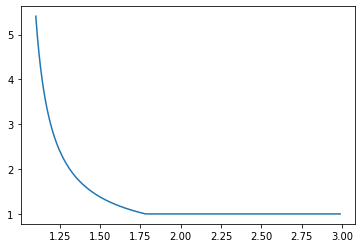

In [3]:
%matplotlib inline

# Exercise 4.2 (d)
x = np.arange(1.1, 3.0, 0.01)
y = np.vectorize(get_theta1)(x)
plt.plot(x, y)

In [4]:
# Exercise 4.3 (a)
import numpy as np
from scipy import optimize

def CIR(tau, r, kappa, alpha, sigma):
    CIR_A, CIR_B = CIR_sub(tau, kappa, alpha, sigma)
    return CIR_A * np.exp(-CIR_B * r)

def CIR_sub(tau, kappa, alpha, sigma):
    gamma = np.sqrt(kappa**2 + 2 * sigma**2)
    numeratorA = 2 * gamma * np.exp((gamma + kappa) * tau / 2)
    numeratorB = 2 * (np.exp(gamma * tau) - 1)
    denominator = (gamma + kappa) * (np.exp(gamma * tau) - 1) + 2 * gamma
    CIR_A = (numeratorA / denominator)**(2 * kappa * alpha / sigma**2)
    CIR_B = numeratorB / denominator
    return CIR_A, CIR_B

def CIR_a(data):
    def CIRaux(theta):
        taus = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 30]
        predict = np.array([-100 * np.log(CIR(tau, *theta)) / tau for tau in taus])
        dev = data - predict
        return np.dot(dev, dev)
    
    init = np.array([1, 1, 1, 1])
    return optimize.minimize(CIRaux, x0=init,  method='Nelder-Mead')

table4_3 = np.array([
    [4.44, 4.49, 4.51, 4.63, 4.63, 4.62, 4.82, 4.77, 5.23],
    [4.45, 4.48, 4.49, 4.61, 4.61, 4.60, 4.84, 4.74, 5.16],
    [4.37, 4.49, 4.53, 4.66, 4.66, 4.65, 4.86, 4.76, 5.18],
    [4.47, 4.47, 4.51, 4.57, 4.57, 4.57, 4.74, 4.68, 5.14],
    [4.48, 4.55, 4.59, 4.72, 4.73, 4.74, 4.91, 4.83, 5.25]
])

params_a = [CIR_a(data) for data in table4_3]
for params in params_a:
    print(params.x)

[0.03909584 1.8291058  0.06332641 1.66226331]
[0.03931213 1.82696152 0.0629367  1.66091515]
[0.03863803 1.82868822 0.0635694  1.66215161]
[0.03972254 1.8290596  0.06228046 1.66703864]
[0.03983449 1.71030602 0.063973   1.52358042]


In [5]:
# Exercise 4.3 (b)
def CIR_b(data):
    def CIRaux(theta):
        rs, params = theta[:5], theta[5:]
        taus = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 30]
        predict = np.array([[-100 * np.log(CIR(tau, r, *params)) / tau for tau in taus] for r in rs])
        dev = data - predict
        return np.sum(dev * dev)
    
    init = np.array(np.ones(8))
    return optimize.minimize(CIRaux, x0=init,  method='Nelder-Mead')

params_b = CIR_b(table4_3)
print(params_b.x)

[0.03512741 0.0350458  0.03471939 0.03499825 0.03641765 1.8761615
 0.08993032 3.39971416]


In [6]:
# Exercise 4.4
import numpy as np
from scipy import optimize

def riskneutral(p, k, v):
    def func_aux(lm):
        vec_plus0 = np.vectorize(lambda x: max(x, 0))
        vec_exp = np.vectorize(np.exp)
        f_sub = vec_exp([np.dot(lm, vec_plus0(k - p_i)) for p_i in p])
        f = f_sub / np.sum(f)
        return v - [np.dot(f, vec_plus0(k_j - p)) for k_j in k]

    return optimize.newton(func_aux, x0=np.zeros(v.shape[0]))

**Exercise 4.5**
Omitted because this has nothing to do with numerical computation.

Note first that upper bound of the frontier is $(\mu_{j^{+}}, \sigma_{j^{+}j^{+}})$ with $j^{+} = \arg \max\{\mu_{j} \}$. Lower bound is $(\mu_{j^{-}}, \sigma_{j^{-}j^{-}})$ with $j^{-} = \arg \min\{\sigma_{jj} \}$. Letting $\bar{\mu}$ lie between the upper and lower bounds, consider the minimization problem:
$$
\min_{\omega \in \Delta^{n}} \frac{1}{2} \omega^{T} \Sigma \omega \quad \text{s.t.} \mu^{T} \omega= \bar{\mu}
$$


C:\Users\Takahiro\Anaconda3\lib\site-packages\scipy\optimize\_constraints.py:410: OptimizeWarning: Equality and inequality constraints are specified in the same element of the constraint list. For efficient use with this method, equality and inequality constraints should be specified in separate elements of the constraint list. 
  "in separate elements of the constraint list. ", OptimizeWarning)


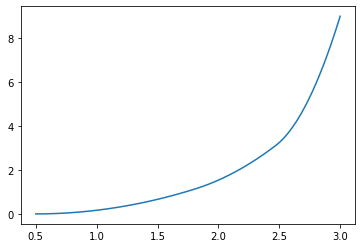

In [7]:
%matplotlib inline

# Exercise 4.6 (continued)

import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

def get_constraint(mubar, len_mu):
    ones = np.ones(len_mu)
    A = np.concatenate((ones.reshape(1, len_mu), mu.reshape(1, len_mu), np.identity(len_mu)), axis=0)
    lb = np.append(np.array([1, mubar]), np.zeros(len_mu)) 
    ub = np.append(np.array([1, mubar]), ones) 
    return optimize.LinearConstraint(A, lb, ub)

def func4_6(mu, Sigma, mubar):
    len_mu = len(mu)
    x0 = np.ones(len_mu) / len_mu
    constraint = get_constraint(mubar, len_mu)
    sol = optimize.minimize(lambda x: Sigma.dot(x).dot(x), x0=x0, constraints=constraint)

    if sol.success == True:
        return float(Sigma.dot(sol.x).dot(sol.x))
    raise ValueError('Not converged')

def mv(mu, Sigma, n):
    mu_min, mu_max = mu.min(), mu.max()
    x = np.linspace(mu_min, mu_max, n)
    y = np.array([func4_6(mu, Sigma, m) for m in x])
    plt.plot(x, y)

mu = np.array([3, 2, 1, 0.5])
Sigma = np.array([[9, 0, 0, 0], [0, 4, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]])
mv(mu, Sigma, 500)
